# Notebook for inferring predictions and comparing model performance
Specify data version, data and saved models get loaded in correspondingly

## Import models and functions needed

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_definitions import FullyConnectedNN
from utils.load_splits import load_splits

In [ ]:
# DATA_VERSION = 

In [2]:
model = FullyConnectedNN()
model.load_state_dict(torch.load("/faststorage/project/MutationAnalysis/Nimrod/results/models/fc/3sC/model.pth")) # So far only the 3sC model is created and saved, would be nice to make this whole inference notebook work with all different versions of the data
# Should this work with different versions of the data one at a time or separate sections for each? Or separate notebooks?

model.eval()

FullyConnectedNN(
  (linear_relu_seq): Sequential(
    (0): LazyLinear(in_features=0, out_features=128, bias=True)
    (1): ReLU()
    (2): LazyLinear(in_features=0, out_features=64, bias=True)
    (3): ReLU()
    (4): LazyLinear(in_features=0, out_features=4, bias=True)
  )
)

## Infer test loss (3sC data)

In [31]:
_, _, _, _, X_test, y_test = load_splits("3sC")
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

test_probs = []
test_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        probs = model.predict_proba(xb)

        test_probs.append(probs.cpu())
        test_targets.append(yb.cpu())

test_probs = torch.cat(test_probs).numpy()
test_targets = torch.cat(test_targets).numpy()

loss = log_loss(test_targets, test_probs)
print(f"Test log loss: {loss}")

Test log loss: 0.6922024670608665


## Generate list of each possible context

In [32]:
df = pd.read_csv("/faststorage/project/MutationAnalysis/Nimrod/data/processed/3mer_subset_C.tsv", sep="\t")

distinct_contexts = df["context"].drop_duplicates().sort_values(ignore_index=True)
distinct_contexts = list(distinct_contexts)

## Use model.predict_proba() to obtain probability distribution of mutation outcomes for each k-mer type

In [33]:
probs = []

def one_hot_encode_3mer(context):
    nucleotides = ['A', 'C', 'G', 'T']
    nuc_to_int = {nuc: i for i, nuc in enumerate(nucleotides)} # Encode nucl to int
    onehot_array = np.concatenate([np.eye(4)[nuc_to_int[nuc]] for nuc in context])
    return torch.as_tensor(onehot_array, dtype=torch.float32)


for context in distinct_contexts:
    context_onehot = one_hot_encode_3mer(context)
    model.eval()
    with torch.no_grad():
        prob_distr = model.predict_proba(context_onehot).detach().numpy()
        probs.append(prob_distr)

nucleotides = ['A', 'C', 'G', 'T']
probs = pd.DataFrame(probs, columns=nucleotides, index=distinct_contexts)
probs

,A,C,G,T
ACA,0.044562,0.780553,0.038019,0.136866
ACC,0.095035,0.734069,0.030725,0.140171
ACG,0.032663,0.256663,0.026562,0.684113
ACT,0.032879,0.782557,0.056236,0.128328
CCA,0.034713,0.825470,0.030725,0.109092
CCC,0.047270,0.783707,0.046041,0.122982
CCG,0.027715,0.328949,0.021816,0.621521
CCT,0.030302,0.803112,0.047595,0.118991
GCA,0.053118,0.820173,0.031309,0.095400
GCC,0.067504,0.763945,0.033289,0.135262


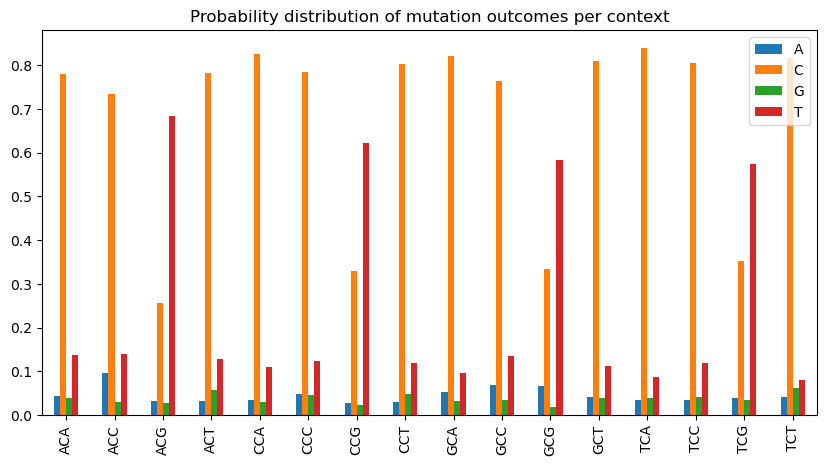

In [38]:
probs.plot(kind="bar", figsize=(10, 5))
plt.title("Probability distribution of mutation outcomes per context")
plt.show()